In [1]:
import numpy as np
import pandas as pd


In [2]:
# Run some checks to make sure everything we need is loaded on the worker nodes
import sys 
ardd = sc.parallelize(xrange(30),30) 
print ardd.map(lambda x: sys.version).distinct().collect()
print ardd.map(lambda x: sys.executable).distinct().collect()
print ardd.map(lambda x: str(sys.path)).distinct().collect()

['2.7.6 (default, Jun 22 2015, 17:58:13) \n[GCC 4.8.2]']
['/usr/bin/python2.7']
["['', u'./com.univocity_univocity-parsers-1.5.1.jar', u'./org.apache.commons_commons-csv-1.1.jar', u'./com.databricks_spark-csv_2.10-1.1.0.jar', u'.', '/home/ubuntu/spark/python/lib/pyspark.zip', '/home/ubuntu/spark/python/lib/py4j-0.9-src.zip', '/home/ubuntu/spark/lib/spark-assembly-1.6.0-hadoop2.6.0.jar', '/opt/ibm/platform/soam/7.1.1/linux-x86_64/lib64', '/var/lib/mesos/slaves/6e7570b0-c38f-4321-9df2-ffdf4c9801ba-S0/frameworks/6e7570b0-c38f-4321-9df2-ffdf4c9801ba-0001/executors/0/runs/ec4b1c6e-bc7a-4448-9000-fd4ec748d8fa/spark-1.6.0-bin-hadoop2.6', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages']"]


In [3]:
import re
import datetime

def find_job_times(driver_num, job_file):
    # find_job_times reads the jobNumFile that has extracted the "Starting run.." and "Finished.." statements
    # Returns a dictionary that contains entries like this: {driver_num: [list of start times]}
    #
    # Read the file and construct a dictionary of job numbers and start times
    jf = open(job_file, 'r')

    # Create dictionary
    jobnumDict = {}

    for line in jf:
        #print line
        if 'Starting' in line:
            match = re.search('Starting run (\d+)', line)
            if match is None:
                print 'Error: no match line 1'
            job = match.group(1)
        else:
            match = re.search('([\d\/]{8}) ([\d:]{8})', line)
            if match is None:
                print 'Error: no match line 2'
            date = match.group(1)
            time = match.group(2)
            #print date[0:2], date[3:5], date[6:8]
            start_time = datetime.datetime(  int(date[0:2])+2000,
                                            int(date[3:5]),
                                            int(date[6:8]),
                                            int(time[0:2]),
                                            int(time[3:5]),
                                            int(time[6:8])  )

            # Add the entry to the dictionary
            #jobnumDict[str(driver_num)+'_'+str(job)] = start_time
            
            # Append job start times to the list of times
            if str(driver_num) in jobnumDict.keys():
                jobnumDict[str(driver_num)] = jobnumDict[str(driver_num)] + [start_time] 
            else:
                jobnumDict[str(driver_num)] = [start_time]
            
    return jobnumDict


In [4]:
import sys
import os
#from test_helper import Test

dataDir = os.path.join('/jason', 'SMB1')

logFile = os.path.join(dataDir, 'driver_output_0.log')
jobNumFile = os.path.join(dataDir, 'driver_jobs_0.txt')


In [5]:
import subprocess
import shlex

def extract_job_start_times(driver):
    # Search the log file for the start of runs and the approximate timestamp
    # Lines look like this:
    # Starting run 0
    # 16/02/10 11:05:11 INFO SparkContext: Running Spark version 1.5.2
    # Starting run 1
    # 16/02/10 11:05:40 INFO SparkContext: Running Spark version 1.5.2
    
    # Construct the log file name
    log_file = os.path.join(dataDir, 'driver_output_' + str(driver) + '.log' )

    # Temp file to store job start and finish lines in
    temp_file = os.path.join(dataDir, 'temp_job_info.txt')
    
    # Script file to run the grep commands
    script_file = os.path.join(dataDir, 'jobnums.sh')
    
    # Call the script that greps the file and saves the lines
    #cmd = './jobnums.sh ' + log_file + ' ' + temp_file
    cmd = script_file + ' ' + log_file + ' ' + temp_file
    #cmd = 'grep \'Starting run \\| INFO SparkContext: Running Spark version 1.5.2\' ' + log_file + ' > ' + temp_file
    print cmd
    subprocess.call(shlex.split(cmd))
    
    # Call find_job_times() to convert the temp_file data into a dictionary
    dict = find_job_times(driver, temp_file)
    
    return dict


In [6]:
# Concatenate all the dictionaries of job start times together to form one big dictionary: startDict 

startDict = {}

for i in range(0,30):
    startDict.update(extract_job_start_times(i))
    
#print startDict['0']
#print 'second list'
#print startDict['1']

/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_0.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_1.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_2.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_3.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_4.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_5.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_6.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_7.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_8.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_9.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_10.log /jason/SMB1/temp_job_info.txt
/jason/SMB1/jobnums.sh /jason/SMB1/driver_output_11.log /jason/S

In [7]:
def get_job_num(driver, timestamp):
    # Using the startDict dictionary, determine the job number based on looking up the start times
    
    # Save the start time of the first job
    firstjobStart = startDict[str(driver)][0]
    
    if timestamp < firstjobStart:
        print 'Error: timestamp for driver ' + str(driver) + ' is less than first start time'
        return -1
    
    # Set the time of the previous job
    prevTime = firstjobStart
    
    for currentTime in startDict[str(driver)]:
        if timestamp >= prevTime:
            if timestamp < currentTime:
                break

    # Return the timestamp
    return startDict[str(driver)].index(currentTime)

In [8]:
get_job_num(0, datetime.datetime(2016, 2, 10, 12, 17, 56))

58

In [9]:
def extract_num_executors(driver):
    # extract_num_executors scans the log file and extracts all the "New executor" statements 
    # and captures the total running
    # Returns a list of tuples of (timestamp, driver, job, num_executors)
    #
    
    # Construct the log file name
    log_file = os.path.join(dataDir, 'driver_output_' + str(driver) + '.log' )

    # Open the log file
    lf = open(log_file, 'r')

    # Exec statement list
    numExecsList = []
    
    for line in lf:
        
        # Check if the line notes a new executor, and grab the total running
        match = re.search('([\d\/]{8}) ([\d:]{8}) .*: New executor .* total is (\d+)', line)
        if match is not None:
            # Capture the timestamp on the line
            date = match.group(1)
            time = match.group(2)
            timestamp = datetime.datetime(  int(date[0:2])+2000,
                                            int(date[3:5]),
                                            int(date[6:8]),
                                            int(time[0:2]),
                                            int(time[3:5]),
                                            int(time[6:8])  )
            num_execs = int(match.group(3))

            # Add the entry to the list
            numExecsList += [(timestamp, driver, get_job_num(driver, timestamp), num_execs)]
            continue
        
        # Check if the line notes the end of a job and record that there are 0 executors running
        match = re.search('([\d\/]{8}) ([\d:]{8}) .*: Shutting down all executors', line)
        if match is not None:
            # Capture the timestamp on the line
            date = match.group(1)
            time = match.group(2)
            timestamp = datetime.datetime(  int(date[0:2])+2000,
                                            int(date[3:5]),
                                            int(date[6:8]),
                                            int(time[0:2]),
                                            int(time[3:5]),
                                            int(time[6:8])  )

            # Add the entry to the list show all executors released
            numExecsList += [(timestamp, driver, get_job_num(driver, timestamp), 0)]
            continue
            
            
             
    return numExecsList


In [10]:
# Scan all the log files for the timestamps of executors running and create the RDD
execsRunningByTime = []

for i in range(0,30):
    execsRunningByTime = execsRunningByTime + extract_num_executors(i)
#print allExecsList

execsRDD = sc.parallelize(execsRunningByTime)

In [11]:
# Check format is: (timestamp, driver, job, numExecs)
execsRDD.take(1)

[(datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, 1)]

In [12]:
# Find max and min timestamps in the execsRDD. This sets the start and end time of the overall test.
execsTS = execsRDD.map(lambda x: x[0])

startTS = execsTS.min()
endTS = execsTS.max()

print startTS, endTS

2016-02-10 11:05:21 2016-02-10 13:27:27


In [13]:
# Calculate the number timestamps we need to generate
numTS = int((endTS - startTS).total_seconds())
numTS

8526

In [14]:
# Generate an array of all possible timestamps for this test, at 1 second apart
times = pd.date_range(startTS, periods=numTS, freq='1s').to_pydatetime()

# Convert the output from numpy format to a plan Python list - 
# Need this because I haven't gotten numpy properly installed on worker node
timelist = times.tolist()  

# Create an empty RDD with just the timestamps
tsRDD = sc.parallelize(timelist)

# transform to same shape as the execsRDD so we can join them
tsRDD2 = tsRDD.map(lambda x: (x, (None,None,None)))

print tsRDD2.take(5)
print tsRDD2.count()

[(datetime.datetime(2016, 2, 10, 11, 5, 21), (None, None, None)), (datetime.datetime(2016, 2, 10, 11, 5, 22), (None, None, None)), (datetime.datetime(2016, 2, 10, 11, 5, 23), (None, None, None)), (datetime.datetime(2016, 2, 10, 11, 5, 24), (None, None, None)), (datetime.datetime(2016, 2, 10, 11, 5, 25), (None, None, None))]
8526


In [15]:
execsRDD2 = execsRDD.map(lambda x: (x[0],(x[1], x[2], x[3])))
execsAllTS = execsRDD2.rightOuterJoin(tsRDD2)
execsAllTS.takeOrdered(20)

[(datetime.datetime(2016, 2, 10, 11, 5, 21), ((0, 1, 1), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 22), ((0, 1, 2), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 22), ((0, 1, 3), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), ((0, 1, 4), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), ((0, 1, 5), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), ((0, 1, 6), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), ((0, 1, 7), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), ((0, 1, 8), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 24), ((0, 1, 9), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 24), ((0, 1, 10), (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 25), (None, (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 26), (None, (None, None, None))),
 (datetime.datetime(2016, 2, 10, 11, 5, 27), (None, (None, No

In [16]:
# Transform back to eliminate the bogus keys
execsFull = execsAllTS.map(lambda x: (x[0], x[1][0][0],x[1][0][1],x[1][0][2]) if x[1][0]<>None else (x[0], 0,None,None))
execsFull.takeOrdered(20)

# Now execsFull is our original execsRDD but with at least one record for every timestamp second over the duration of the test

[(datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 22), 0, 1, 2),
 (datetime.datetime(2016, 2, 10, 11, 5, 22), 0, 1, 3),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), 0, 1, 4),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), 0, 1, 5),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), 0, 1, 6),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), 0, 1, 7),
 (datetime.datetime(2016, 2, 10, 11, 5, 23), 0, 1, 8),
 (datetime.datetime(2016, 2, 10, 11, 5, 24), 0, 1, 9),
 (datetime.datetime(2016, 2, 10, 11, 5, 24), 0, 1, 10),
 (datetime.datetime(2016, 2, 10, 11, 5, 25), 0, None, None),
 (datetime.datetime(2016, 2, 10, 11, 5, 26), 0, None, None),
 (datetime.datetime(2016, 2, 10, 11, 5, 27), 0, None, None),
 (datetime.datetime(2016, 2, 10, 11, 5, 28), 0, None, None),
 (datetime.datetime(2016, 2, 10, 11, 5, 29), 0, None, None),
 (datetime.datetime(2016, 2, 10, 11, 5, 30), 0, None, None),
 (datetime.datetime(2016, 2, 10, 11, 5, 31), 0, None, None),
 (datetime.datetime(20

In [17]:
# Change key to (timestamp, driver, job). The value is the number of execs
# We're doing this so we can get rid of duplicate exec counts in the same time period
execsByTimeDriverJob = execsFull.map(lambda row: ((row[0],row[1], row[2]), row[3]))

In [18]:
execsByTimeDriverJob.take(1)

[((datetime.datetime(2016, 2, 10, 11, 24, 26), 0, None), None)]

In [19]:
# Reduce down by getting the max number of execs at any unique timestamp+driver+job
execsByTimeDriverJobReducedRDD = execsByTimeDriverJob.reduceByKey(lambda a,b: b if b>a else a)

In [20]:
execsByTimeDriverJobReducedRDD.count()

9407

In [21]:
# Unbundle the RDD to get it back to the original
# To this format: (timestamp, driver, job, numExecs)
execsRDDClean = execsByTimeDriverJobReducedRDD.map(lambda row: (row[0][0],row[0][1],row[0][2], row[1]))

In [22]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)
schema = StructType([
        StructField("TIME", TimestampType(), True),
        StructField("DRIVER", IntegerType(), True),
        StructField("JOB", IntegerType(), True),
        StructField("EXECS", IntegerType(), True)  ])

execs_df = sqlContext.createDataFrame(execsRDDClean, schema)

In [23]:
execs_df
print execs_df.take(2)

[Row(TIME=datetime.datetime(2016, 2, 10, 12, 12, 36), DRIVER=7, JOB=47, EXECS=1), Row(TIME=datetime.datetime(2016, 2, 10, 12, 43, 49), DRIVER=5, JOB=49, EXECS=0)]


In [24]:

execs_pd = execs_df.toPandas()

In [25]:
execs_pd

,TIME,DRIVER,JOB,EXECS
0,2016-02-10 12:12:36,7,47,1
1,2016-02-10 12:43:49,5,49,0
2,2016-02-10 13:13:03,21,38,0
3,2016-02-10 12:50:21,20,59,0
4,2016-02-10 11:29:26,8,16,1
5,2016-02-10 12:22:35,27,36,1
6,2016-02-10 13:26:37,0,NaN,NaN
7,2016-02-10 12:36:34,0,NaN,NaN
8,2016-02-10 12:24:10,0,NaN,NaN
9,2016-02-10 11:47:53,0,43,1


In [26]:
# Use pandas.pivot to fill in the missing values on each timestamp
# First fill forward with 'pad' so each missing value takes the last known value from an earlier timestamp
# Next fill 0s so all the initial missing data is marked as 0 executors
execsbydriver_pd = execs_pd.pivot(index='TIME', columns='DRIVER', values='EXECS').fillna(method='pad').fillna(0)


In [27]:
execsbydriver_pd['TOTAL'] = execsbydriver_pd.sum(axis=1)
execsbydriver_pd

DRIVER,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,TOTAL
TIME,,,,,,,,,,,,,,,,,,,,,
2016-02-10 11:05:21,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2016-02-10 11:05:22,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2016-02-10 11:05:23,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2016-02-10 11:05:24,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2016-02-10 11:05:25,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2016-02-10 11:05:26,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2016-02-10 11:05:27,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2016-02-10 11:05:28,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2016-02-10 11:05:29,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10


In [29]:
# Use .info() to see the structure of the pandas object
execsbydriver_pd.info()

# .dtypes shows the data types of the columns
execsbydriver_pd.dtypes

# describe() shows summary stats on the dataframe
pd.set_option("display.max_columns",100)
execsbydriver_pd.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8526 entries, 2016-02-10 11:05:21 to 2016-02-10 13:27:26
Data columns (total 31 columns):
0        8526 non-null float64
1        8526 non-null float64
2        8526 non-null float64
3        8526 non-null float64
4        8526 non-null float64
5        8526 non-null float64
6        8526 non-null float64
7        8526 non-null float64
8        8526 non-null float64
9        8526 non-null float64
10       8526 non-null float64
11       8526 non-null float64
12       8526 non-null float64
13       8526 non-null float64
14       8526 non-null float64
15       8526 non-null float64
16       8526 non-null float64
17       8526 non-null float64
18       8526 non-null float64
19       8526 non-null float64
20       8526 non-null float64
21       8526 non-null float64
22       8526 non-null float64
23       8526 non-null float64
24       8526 non-null float64
25       8526 non-null float64
26       8526 non-null float64
27       8526 non-nu

DRIVER,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,TOTAL
count,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000
mean,0.333451,0.304246,0.309641,0.302956,0.269998,0.268825,0.337790,0.265189,0.263195,0.264954,0.264837,0.263312,0.269763,0.264602,0.382360,0.335327,0.269763,0.262843,0.258269,0.263078,0.261553,0.443584,0.260497,0.263312,0.512550,0.266948,0.262139,0.267652,0.267652,0.260849,8.821135
std,0.943880,0.751365,0.703952,0.659731,0.511506,0.501710,0.809849,0.469030,0.467023,0.460583,0.458225,0.445488,0.476491,0.455794,0.978568,0.784475,0.466037,0.440204,0.437708,0.440330,0.439506,1.208589,0.438932,0.440456,1.537647,0.461850,0.439824,0.465744,0.464735,0.439124,1.722449
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000
max,10.000000,10.000000,6.000000,4.000000,3.000000,3.000000,5.000000,3.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,8.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,10.000000,1.000000,1.000000,10.000000,2.000000,1.000000,2.000000,2.000000,1.000000,10.000000


In [30]:
#print b.take([7,8,9,10,11,1000,1200,1300,1500])
print execsbydriver_pd.take([7,8,9,10,11,1000,1200,1300,1500])

DRIVER                0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  \
TIME                                                                         
2016-02-10 11:05:28  10  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
2016-02-10 11:05:29  10  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
2016-02-10 11:05:30  10  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
2016-02-10 11:05:31  10  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
2016-02-10 11:05:32  10  0  0  0  0  0  0  0  0  0   0   0   0   0   0   0   
2016-02-10 11:22:01   1  0  0  1  1  1  0  0  0  1   2   0   0   1   0   1   
2016-02-10 11:25:21   1  0  0  1  0  0  0  0  1  1   1   1   0   1   0   0   
2016-02-10 11:27:01   0  0  1  0  1  0  1  0  0  0   0   1   0   0   1   1   
2016-02-10 11:30:21   1  0  0  1  1  0  0  1  0  0   0   0   0   1   0   1   

DRIVER               16  17  18  19  20  21  22  23  24  25  26  27  28  29  \
TIME                                                          

In [73]:
# Set up for plotting

%matplotlib inline

import matplotlib.pyplot as plt
# matplotlib.patches allows us create colored patches, we can use for legends in plots
#import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
#import seaborn as sns

#print 'pandas.__version__ is ', pd.__version__
#print 'matplotlib.__version__ is ', matplotlib.__version__    

#sns.set_style("white")


<function matplotlib.pyplot.show>

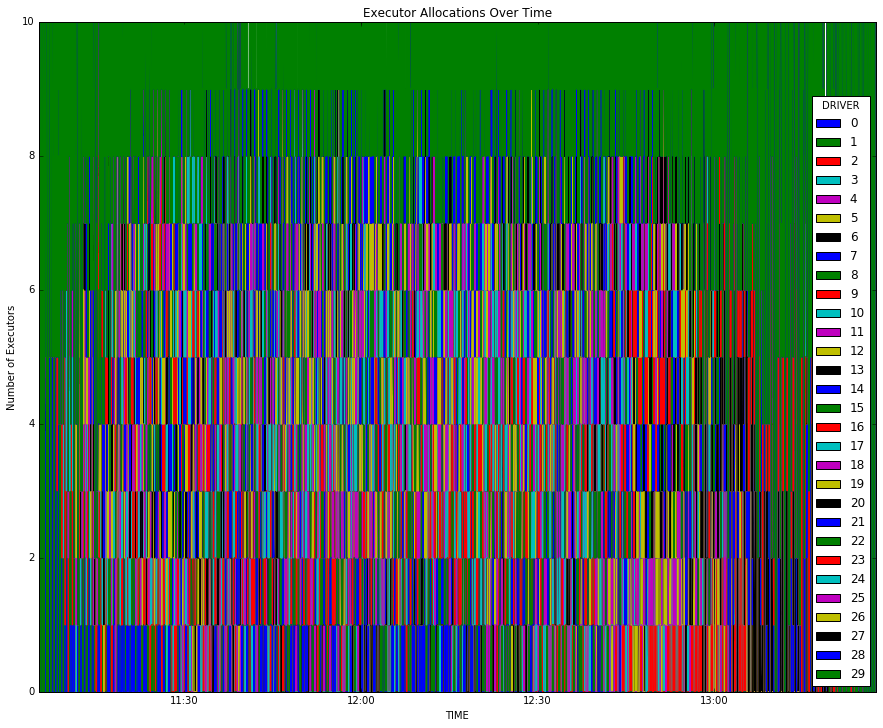

In [91]:
# Visualize the data as an area plot
plt.figure(figsize=(15,12))

# Remove the Totals column
execs_subset_pd = execsbydriver_pd.ix[:,0:30]

execs_subset_pd.plot.area(figsize=(15,12), title='Executor Allocations Over Time')
plt.ylabel('Number of Executors')

plt.show

<function matplotlib.pyplot.show>

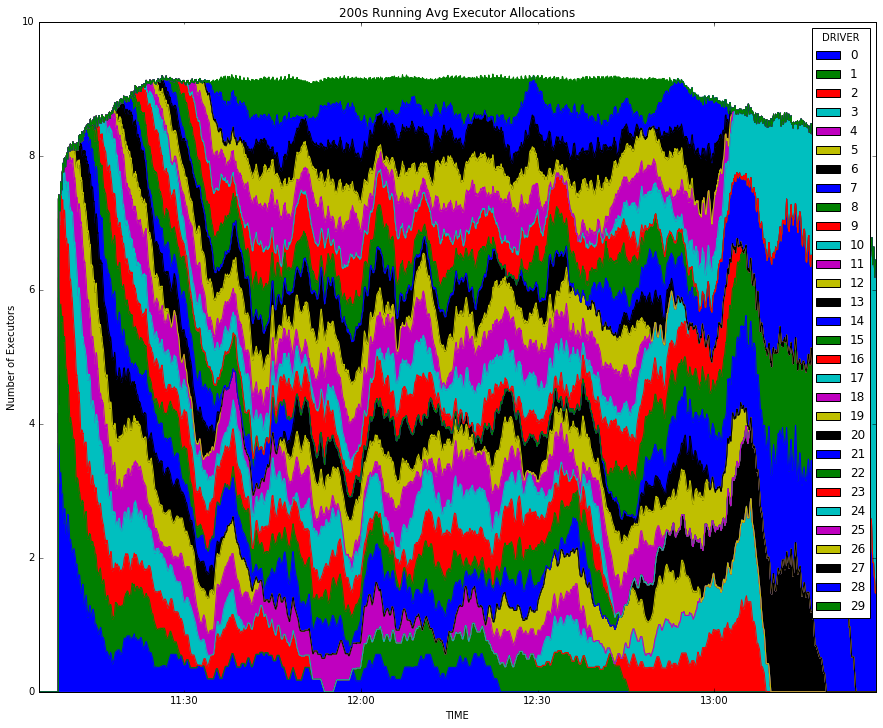

In [89]:
# Visualize the data as an area plot
plt.figure(figsize=(15,12))

# Take a rolling average of the num of execs so it is less volatile in the graph
execs_smooth_pd = pd.rolling_mean(execs_subset_pd, 200)

execs_smooth_pd.plot.area(figsize=(15,12), title='200s Running Avg Executor Allocations')
plt.ylabel('Number of Executors')

plt.show

<H1>Task Data Analysis</H1>
In the next section we repeat many of the same calculations on the tast start and stop times to see how well all 40 slots across the 10 hosts are allocated.

In [33]:
def extract_task_stats(driver):
    # extract_task_stats scans the log file and extracts all the "Starting task" and "Finished task" statements 
    # and captures the total running on each executor (host)
    # Returns a list of tuples of (timestamp, driver, job, task, executor, event), 
    # where executor is the name of the host and event is +1 or -1
    #
    
    # Construct the log file name
    log_file = os.path.join(dataDir, 'driver_output_' + str(driver) + '.log' )

    # Open the log file
    lf = open(log_file, 'r')

    # Initialize the return data structure
    taskStatsList = []
    
    for line in lf:
        
        # Check if the line notes the start of a task and record which host it is running on
        match = re.search('([\d\/]{8}) ([\d:]{8}) .*: Starting task .* in stage .* \(TID (\d+), (\w+)', line)
        if match is not None:
            # Capture the timestamp on the line
            date = match.group(1)
            time = match.group(2)
            timestamp = datetime.datetime(  int(date[0:2])+2000,
                                            int(date[3:5]),
                                            int(date[6:8]),
                                            int(time[0:2]),
                                            int(time[3:5]),
                                            int(time[6:8])  )
            task = match.group(3)
            executor = match.group(4)

            # Add the entry to the list show all executors released
            taskStatsList += [(timestamp, driver, get_job_num(driver, timestamp), task, executor, 1)]
            continue
             
        # Check if the line notes the end of a task and record which host it was running on
        match = re.search('([\d\/]{8}) ([\d:]{8}) .*: Finished task .* in stage .* \(TID (\d+)\) in \d* ms on (\w+)', line)
        if match is not None:
            # Capture the timestamp on the line
            date = match.group(1)
            time = match.group(2)
            timestamp = datetime.datetime(  int(date[0:2])+2000,
                                            int(date[3:5]),
                                            int(date[6:8]),
                                            int(time[0:2]),
                                            int(time[3:5]),
                                            int(time[6:8])  )
            task = match.group(3)
            executor = match.group(4)

            # Add the entry to the list show all executors released
            taskStatsList += [(timestamp, driver, get_job_num(driver, timestamp), task, executor, -1)]
            continue
             
    return taskStatsList


In [34]:
# Scan logfiles again, this time pulling out all the tast start and finish times
taskStatsList = []

for i in range(0,30):
    taskStatsList = taskStatsList + extract_task_stats(i)
#print allExecsList

tasksRDD = sc.parallelize(taskStatsList)

In [35]:
tasksRDD.count()

432000

In [36]:
# Using the timestamp RDD that was created earlier, ensure there is row for each possible time

# Transform tsRDD to same shape as the tasksRDD so we can join them
tsRDDforTasks = tsRDD.map(lambda x: (x, (None,None,None,None,None)))

print tsRDDforTasks.take(5)
print tsRDDforTasks.count()

[(datetime.datetime(2016, 2, 10, 11, 5, 21), (None, None, None, None, None)), (datetime.datetime(2016, 2, 10, 11, 5, 22), (None, None, None, None, None)), (datetime.datetime(2016, 2, 10, 11, 5, 23), (None, None, None, None, None)), (datetime.datetime(2016, 2, 10, 11, 5, 24), (None, None, None, None, None)), (datetime.datetime(2016, 2, 10, 11, 5, 25), (None, None, None, None, None))]
8526


In [37]:
# Join the original tasksRDD with the tsRDDforTasks so that each unique timestamp is represented
tasksRDD2 = tasksRDD.map(lambda x: (x[0],(x[1], x[2], x[3], x[4], x[5])))
tasksAllTS = tasksRDD2.rightOuterJoin(tsRDDforTasks)
#tasksAllTS.takeOrdered(20)

# Transform back to eliminate the bogus keys
tasksFull = tasksAllTS.map(lambda x: (x[0], x[1][0][0],x[1][0][1],x[1][0][2],x[1][0][3],x[1][0][4]) if x[1][0]<>None else (x[0], 0,None,None,None,None))
tasksFull.takeOrdered(10)

# Now tasksFull is our original tasksRDD but with at least one record for every timestamp second over the duration of the test

[(datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '0', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '1', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '10', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '11', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '2', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '3', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '4', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '5', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '6', 'red24', 1),
 (datetime.datetime(2016, 2, 10, 11, 5, 21), 0, 1, '7', 'red24', 1)]

In [38]:
# Simplify the RDD to just ((timestamp, executor), event), with the time and executor forming a new key
tasksSimple = tasksFull.map(lambda x: ((x[0], x[4]), x[5]))

# Aggregate all events on a given executor during a single timestamp (1sec); then unbundle the key
taskAgg = tasksSimple.reduceByKey(lambda a,b: a+b).map(lambda x: (x[0][0], x[0][1], x[1]))

# Unbundle the key to get back to normal shape

taskAgg.take(30)

[(datetime.datetime(2016, 2, 10, 13, 19, 14), 'red16', 5),
 (datetime.datetime(2016, 2, 10, 12, 14, 47), 'red20', -2),
 (datetime.datetime(2016, 2, 10, 12, 0, 50), 'red16', -5),
 (datetime.datetime(2016, 2, 10, 12, 26, 55), 'red19', -3),
 (datetime.datetime(2016, 2, 10, 11, 56), 'red22', -12),
 (datetime.datetime(2016, 2, 10, 12, 36, 34), 'red16', -12),
 (datetime.datetime(2016, 2, 10, 11, 41, 11), 'red22', 28),
 (datetime.datetime(2016, 2, 10, 12, 8, 59), 'red22', 26),
 (datetime.datetime(2016, 2, 10, 11, 14, 41), 'red25', -26),
 (datetime.datetime(2016, 2, 10, 12, 37, 20), 'red22', 0),
 (datetime.datetime(2016, 2, 10, 12, 31, 56), 'red20', -4),
 (datetime.datetime(2016, 2, 10, 12, 38, 1), 'red17', 4),
 (datetime.datetime(2016, 2, 10, 12, 32, 17), 'red15', 19),
 (datetime.datetime(2016, 2, 10, 11, 34, 39), 'red23', -2),
 (datetime.datetime(2016, 2, 10, 11, 35, 7), 'red20', 15),
 (datetime.datetime(2016, 2, 10, 12, 29, 21), 'red16', -2),
 (datetime.datetime(2016, 2, 10, 12, 33, 54), 'r

In [39]:
#Imports defined above
#from pyspark.sql import SQLContext
#from pyspark.sql.types import *

#sqlContext = SQLContext(sc)
taskschema = StructType([
        StructField("TIME", TimestampType(), True),
        StructField("EXECUTOR", StringType(), True),
        StructField("EVENT", IntegerType(), True),
    ])

tasks_df = sqlContext.createDataFrame(taskAgg, taskschema)

In [40]:
tasks_df
print tasks_df.take(2)

[Row(TIME=datetime.datetime(2016, 2, 10, 13, 19, 14), EXECUTOR=u'red16', EVENT=5), Row(TIME=datetime.datetime(2016, 2, 10, 12, 14, 47), EXECUTOR=u'red20', EVENT=-2)]


In [41]:
# Change dataframe to Pandas dataframe
tasks_pd = tasks_df.toPandas()
tasks_pd

,TIME,EXECUTOR,EVENT
0,2016-02-10 13:19:14,red16,5
1,2016-02-10 12:14:47,red20,-2
2,2016-02-10 12:00:50,red16,-5
3,2016-02-10 12:26:55,red19,-3
4,2016-02-10 11:56:00,red22,-12
5,2016-02-10 12:36:34,red16,-12
6,2016-02-10 11:41:11,red22,28
7,2016-02-10 12:08:59,red22,26
8,2016-02-10 11:14:41,red25,-26
9,2016-02-10 12:37:20,red22,0


In [42]:
# Use pandas.pivot to break out the executor stats into separate columns
# Drop the NaN column because we don't need it anymore, and fill all the remaining NaN values for events with 0
# Then convert all the values to a cumulative sum in each column so we have the total tasks running
tasksPivot_pd = tasks_pd.pivot(index='TIME', columns='EXECUTOR', values='EVENT') \
                                                .dropna(axis=1,how='all') \
                                                .fillna(0) \
                                                .cumsum(0)


In [43]:
tasksPivot_pd

EXECUTOR,red15,red16,red17,red18,red19,red20,red22,red23,red24,red25
TIME,,,,,,,,,,
2016-02-10 11:05:21,0,0,0,0,0,0,0,0,12,0
2016-02-10 11:05:22,0,0,8,0,0,0,7,0,12,0
2016-02-10 11:05:23,0,0,8,1,0,0,7,5,12,7
2016-02-10 11:05:24,0,0,8,1,0,0,7,5,2,7
2016-02-10 11:05:25,0,0,0,1,0,0,2,0,0,0
2016-02-10 11:05:26,4,5,4,5,0,4,4,4,5,5
2016-02-10 11:05:27,4,5,4,5,0,4,4,4,5,5
2016-02-10 11:05:28,4,5,0,0,0,4,0,0,0,0
2016-02-10 11:05:29,4,5,0,0,0,4,0,0,0,0


In [46]:
tasksPivot_pd.describe()

EXECUTOR,red15,red16,red17,red18,red19,red20,red22,red23,red24,red25
count,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000,8526.000000
mean,17.215693,16.722730,16.691063,16.678513,19.243139,17.197865,16.750997,16.332395,16.659629,16.574830
std,12.857652,13.397179,13.477977,12.860104,14.184933,12.934907,13.306600,13.612501,13.315016,13.095435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000
50%,18.000000,13.000000,13.000000,16.000000,32.000000,15.000000,13.000000,11.000000,12.000000,14.000000
75%,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
max,32.000000,32.000000,33.000000,33.000000,36.000000,32.000000,32.000000,33.000000,33.000000,32.000000


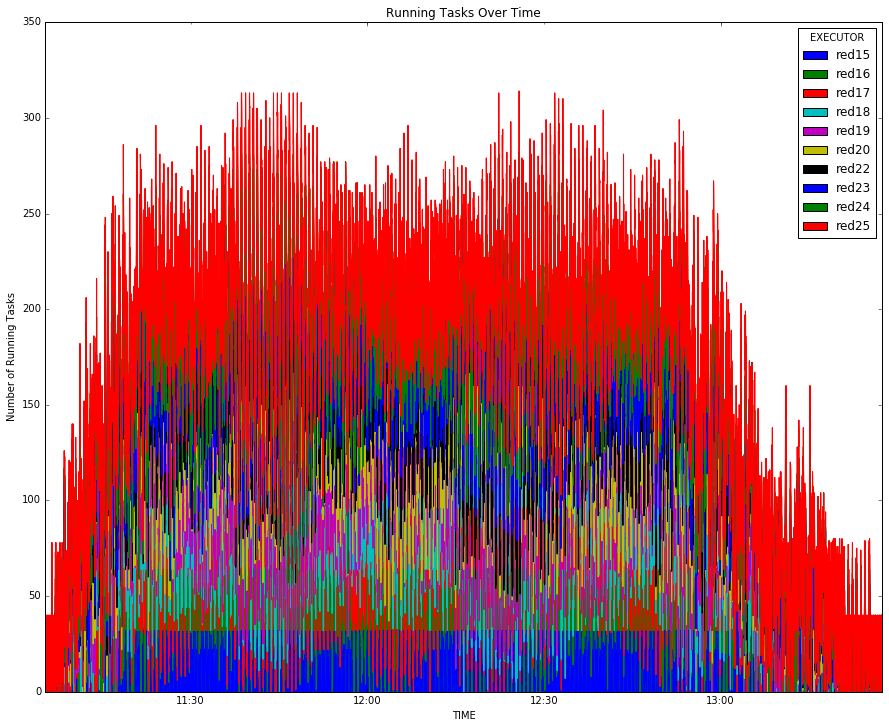

In [90]:
plt.figure(figsize=(15,12))

tasksPivot_pd.plot.area(figsize=(15,12), title='Running Tasks Over Time')

plt.ylabel('Number of Running Tasks')

plt.show

plt.show()

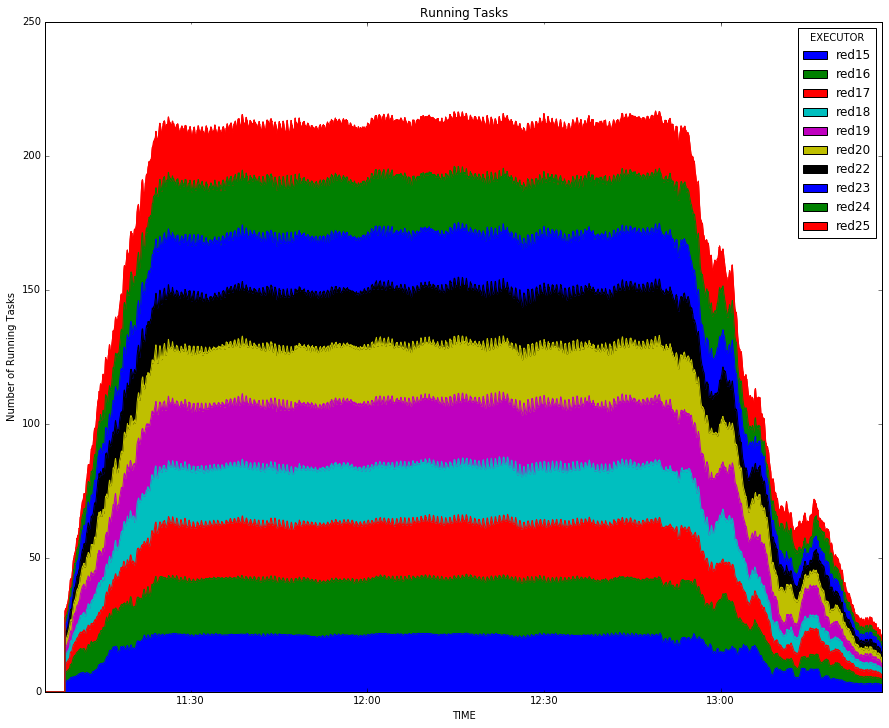

In [86]:
plt.figure(figsize=(15,12))

# Take a rolling average of the num of tasks so it is less volatile in the graph
tasks_smooth_pd = pd.rolling_mean(tasksPivot_pd, 200)

tasks_smooth_pd.plot.area(figsize=(15,12), title='Running Tasks')

plt.ylabel('Number of Running Tasks')

plt.show

plt.show()